# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

## Import the necessary libraries

In [ ]:
import cv2
import numpy as np
import pandas as pd
np.random.seed(1)
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import csv

In [ ]:
from keras import Model
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.applications.vgg16 import VGG16
from keras.layers import GlobalAveragePooling2D
from keras.layers import RepeatVector,Conv1D,Flatten,Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from keras.utils import Sequence
from keras.backend import epsilon
import tensorflow as tf
from keras.applications.resnet50 import ResNet50,preprocess_input

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Change directory

In [ ]:
pwd

'/content/drive/My Drive/lab/9- Advance Computer Vision'

In [ ]:
import os
os.chdir('/content/drive/MyDrive/lab/9- Advance Computer Vision')

In [ ]:
ls

 Dataset-Images_racoon.rar  'Questions - Lab on ACV.ipynb'
 Dataset-Train_labels.csv   'R9 - ACV - Internal_Lab_Solutions.ipynb'
 images/                    'Solutions- Lab on ACV.ipynb'
 model.png


### Load the training data from train.csv file

In [ ]:
train = pd.read_csv('Dataset-Train_labels.csv')

### Print the shape of the train dataset

In [ ]:
train.shape

(173, 8)

### Print the head of the dataset

In [ ]:
train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127


### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [ ]:
IMAGE_SIZE = 128

### With the help of csvr.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [ ]:
with open('Dataset-Train_labels.csv','r') as csvfile:
    paths = []
    coords = np.zeros((sum(1 for line in csvfile) - 1, 4))
    spamreader = csv.reader(csvfile, delimiter=',')
    csvfile.seek(0)
    next(spamreader, None)
    for i,row in enumerate(spamreader):
        #print(row)
        for j, r in enumerate(row): # Parse row with seven entities
            #print(i)
            if((j!= 0) & (j!=3)):
                row[j] = int(r)
            
        #print(row)      
        path, width, height, class_, xmin, ymin, xmax, ymax = row
        paths.append(path)
        #print(i)
        coords[i,0] = xmin * IMAGE_SIZE / width
        coords[i,1] = ymin * IMAGE_SIZE / height
        coords[i,2] = xmax * IMAGE_SIZE / width # Normalize bounding box by image size
        coords[i,3] = ymax * IMAGE_SIZE / height

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [ ]:
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)

for i, f in enumerate(paths):
     img = Image.open('images/'+ f) # Read image
     img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
     img = img.convert('RGB')
     batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))
      

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [ ]:
ALPHA = 1.0

In [ ]:
model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA) # Load pre-trained mobilenet
# Do not include classification (top) layer

# to freeze layers, except the new top layer, of course, which will be added below
for layer in model.layers:
    layer.trainable = False

# Add new top layer which is a conv layer of the same size as the previous layer so that only 4 coords of BBox can be output
x = model.layers[-1].output
x = Conv2D(4, kernel_size=4, name="coords")(x)
# In the line above kernel size should be 3 for img size 96, 4 for img size 128, 5 for img size 160 etc.
x = Reshape((4,))(x) # These are the 4 predicted coordinates of one BBox

model = Model(inputs=model.input, outputs=x)

## Plot the model and view the whole skeleton using plot_model.

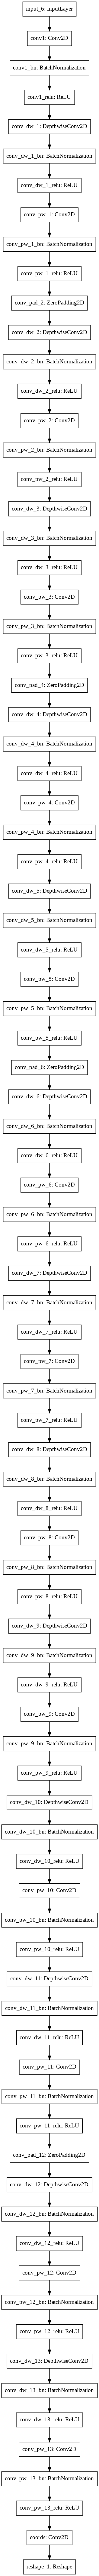

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

### Define a custom loss function IoU which calculates Intersection Over Union

In [ ]:
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_function(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [ ]:
gt = coords
len(batch_images)
print(len(coords))
model.compile(optimizer='Adam', loss='mse', metrics=[IoU]) # Regression loss is MSE
model.fit(batch_images,gt, epochs=30,batch_size = 32, verbose=1)

173
Epoch 1/30
6/6 [==============================] - 1s 53ms/step - loss: 5030.7733 - IoU: 0.0570
Epoch 2/30
6/6 [==============================] - 0s 52ms/step - loss: 1195.9073 - IoU: 0.3163
Epoch 3/30
6/6 [==============================] - 0s 55ms/step - loss: 363.2160 - IoU: 0.5754
Epoch 4/30
6/6 [==============================] - 0s 54ms/step - loss: 551.7381 - IoU: 0.5356
Epoch 5/30
6/6 [==============================] - 0s 54ms/step - loss: 489.6343 - IoU: 0.5420
Epoch 6/30
6/6 [==============================] - 0s 53ms/step - loss: 282.3960 - IoU: 0.6294
Epoch 7/30
6/6 [==============================] - 0s 53ms/step - loss: 221.5609 - IoU: 0.6275
Epoch 8/30
6/6 [==============================] - 0s 53ms/step - loss: 205.0081 - IoU: 0.6403
Epoch 9/30
6/6 [==============================] - 0s 54ms/step - loss: 166.9321 - IoU: 0.6775
Epoch 10/30
6/6 [==============================] - 0s 51ms/step - loss: 158.1511 - IoU: 0.7050
Epoch 11/30
6/6 [==============================] - 0s

### Pick a test image from the given data

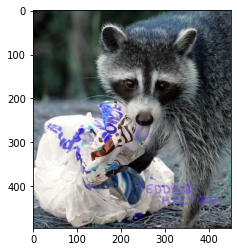

In [ ]:
# Pick a test image, run model, show image, and show predicted bounding box overlaid on the image
filename = 'images/raccoon-10.jpg'
unscaled = cv2.imread(filename) # Original image for display
plt.imshow(unscaled)

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [ ]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE)) # Rescaled image to run the network
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

### Predict the coordinates of the bounding box for the given test image

In [ ]:
region = model.predict(x=np.array([feat_scaled]))[0] # Predict the BBox

In [ ]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

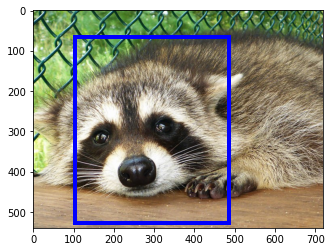

In [ ]:
im = Image.open('images/raccoon-20.jpg')

# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(im)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), x1, y1, linewidth=4, edgecolor='b', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

# VGG 16 Implementation
### Define a variable Image_size which takes accurate input according to the VGG16 model. 

In [ ]:
IMAGE_SIZE=224

### With the help of csvr.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 224 * 224 

In [ ]:
import csv
with open('Dataset-Train_labels.csv','r') as csvfile:
    paths = []
    coords = np.zeros((sum(1 for line in csvfile) - 1, 4))
    spamreader = csv.reader(csvfile, delimiter=',')
    csvfile.seek(0)
    next(spamreader, None)
    for i,row in enumerate(spamreader):
        #print(row)
        for j, r in enumerate(row): # Parse row with seven entities
            #print(i)
            if((j!= 0) & (j!=3)):
                row[j] = int(r)
            
        #print(row)      
        path, width, height, class_, xmin, ymin, xmax, ymax = row
        paths.append(path)
        #print(i)
        coords[i,0] = xmin * IMAGE_SIZE / width
        coords[i,1] = ymin * IMAGE_SIZE / height
        coords[i,2] = xmax * IMAGE_SIZE / width # Normalize bounding box by image size
        coords[i,3] = ymax * IMAGE_SIZE / height

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the VGG16 accepts 3 channels as inputs   

In [ ]:
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)

for i, f in enumerate(paths):
     img = Image.open('images/'+ f) # Read image
     img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
     img = img.convert('RGB')
     batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))
      

### Define a vgg16 model and plot the model using plot_model function.
Hint:- Use RepeatVector,Conv1D,GlobalAveragePooling2D

In [ ]:
model_vgg=VGG16(weights='imagenet',include_top=False,input_shape=(IMAGE_SIZE,IMAGE_SIZE,3))

for layer in model_vgg.layers:
  layer.trainable=False


x2=model_vgg.output
x2=GlobalAveragePooling2D()(x2)
x2=RepeatVector(8)(x2)
x2=Conv1D(4,kernel_size=8,name="coords")(x2)
x2=Flatten()(x2)

Model_vgg=Model(inputs=model_vgg.input,outputs=x2)

### Plot the Vgg16 model using plot_model function.

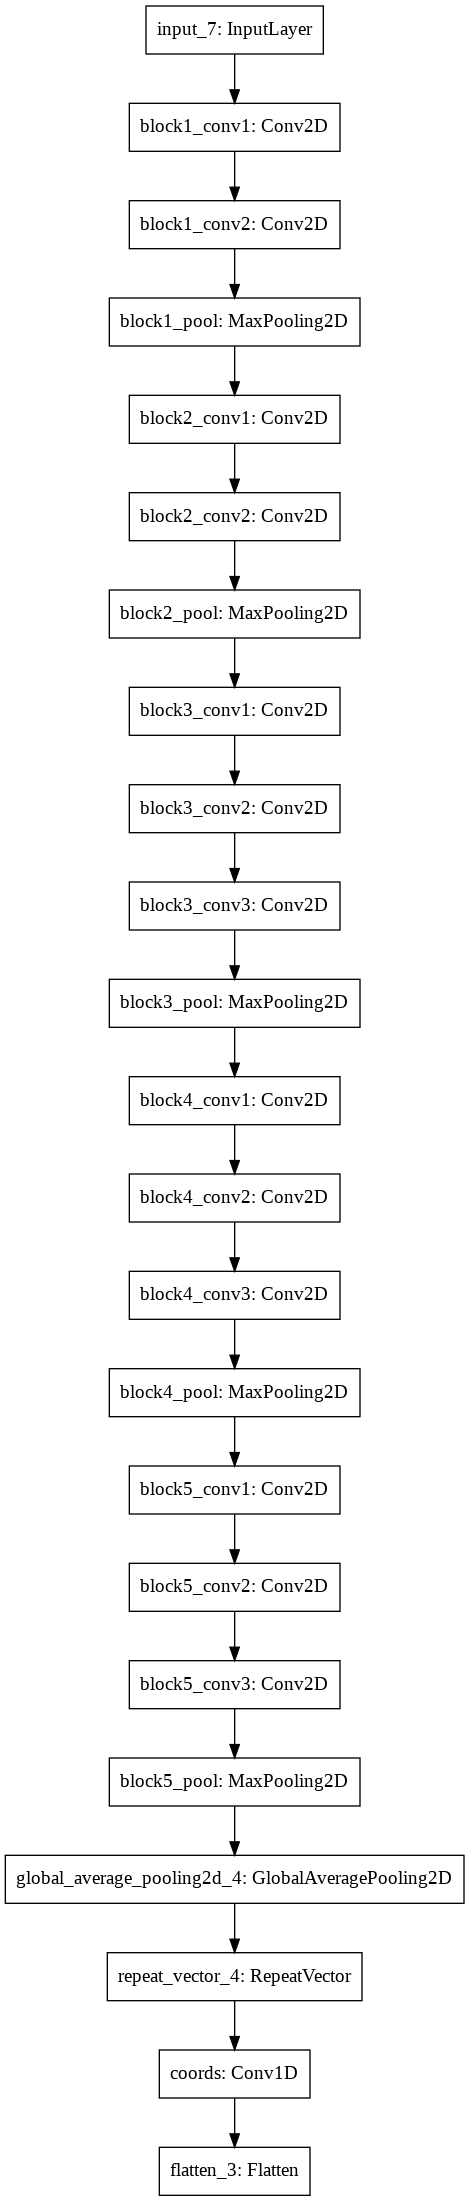

In [ ]:
tf.keras.utils.plot_model(
    Model_vgg, to_file='model.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [ ]:
gt = coords
len(batch_images)
print(len(coords))
Model_vgg.compile(optimizer='Adam', loss='mse', metrics=[IoU]) # Regression loss is MSE
Model_vgg.fit(batch_images,gt, epochs=30,batch_size = 32, verbose=1)

173
Epoch 1/30
6/6 [==============================] - 1s 96ms/step - loss: 15656.8613 - IoU: 0.0364
Epoch 2/30
6/6 [==============================] - 1s 101ms/step - loss: 5908.4799 - IoU: 0.1882
Epoch 3/30
6/6 [==============================] - 1s 100ms/step - loss: 2287.6328 - IoU: 0.4091
Epoch 4/30
6/6 [==============================] - 1s 102ms/step - loss: 1719.3240 - IoU: 0.4972
Epoch 5/30
6/6 [==============================] - 1s 98ms/step - loss: 2030.7081 - IoU: 0.4830
Epoch 6/30
6/6 [==============================] - 1s 99ms/step - loss: 1899.7250 - IoU: 0.4985
Epoch 7/30
6/6 [==============================] - 1s 100ms/step - loss: 1375.1269 - IoU: 0.5212
Epoch 8/30
6/6 [==============================] - 1s 101ms/step - loss: 1349.9929 - IoU: 0.5226
Epoch 9/30
6/6 [==============================] - 1s 103ms/step - loss: 1370.5850 - IoU: 0.5154
Epoch 10/30
6/6 [==============================] - 1s 101ms/step - loss: 1289.6394 - IoU: 0.5303
Epoch 11/30
6/6 [====================

### Pick a test image from the given data

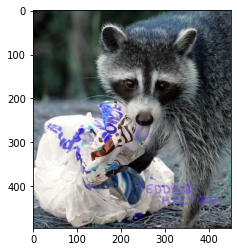

In [ ]:
# Pick a test image, run model, show image, and show predicted bounding box overlaid on the image

filename = 'images/raccoon-10.jpg'
unscaled = cv2.imread(filename) # Original image for display
plt.imshow(unscaled)

### Resize the image to 224 * 224 and preprocess the image for the VGG16

In [ ]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE)) # Rescaled image to run the network
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

### Predict the coordinates of the bounding box for the given test image

In [ ]:
region = Model_vgg.predict(x=np.array([feat_scaled]))[0] # Predict the BBox

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

In [ ]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)

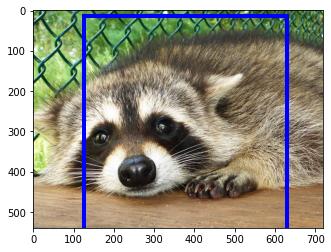

In [ ]:
im = Image.open('images/raccoon-20.jpg')

# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(im)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), x1, y1, linewidth=4, edgecolor='b', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()